# Network-based association analysis to infer disease-gene relationship using Neo4J


## Introduction and Objective

The main objective of human genetic research is to identify genomic sequence variations that may play a role in the development of diseases. Thus information is critical to generate insights into the biology of health and disease that can support clinical translation. However the complexity of some diseases that implies the activity of several genes / proteins challenges our understanding about these pathologies. The technological boost in molecular biology that occured in the last decades prompted scientists to develop and establish several experimental approaches to identify disease-gene associations (i.e, genome-wide association studies, RNA interference screens, and linkage studies). As a result, many databases of diseases and genes have been developed and made available to the community. Consequently computational methods are now critical tools to retrieve and analyze these data for a better understanding of pathological mechanisms. Herein we are going to present and demonstrate how to harness Neo4j, a grah database tool that sits on top of a query language called Cypher to assess the relations between genes and diseases. The main objective will be to illustrate how easy and flexible this can be to quickly query data and perform simple analysis to investigate relation between genetic variants and diseases. In this regards we are going to use DisGeNET that is one of the largest available repositories of genes and variants involved in human diseases.

## Before Starting

If anyone wants to go through this notebook we strongly advise you to first install the [Neo4J](https://neo4j.com/) desktop app available on their website. Once done, we are going to use a python package called [py2neo](https://py2neo.org/v4/) that provides an API to direclty interact with our graph database. To be able to interact with your database you need to run its server locally using the Neo4J app. The `Graph()` class from *py2neo* provides an interface to directly connect to Neo4J database server and run the expected queries. 

To check if you have all needed packages you can run the cell below.

In [1]:
import sys
import subprocess
import pkg_resources

required = {'pandas', 'py2neo', 'matplotlib','neo4jupyter'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import neo4jupyter
from py2neo import Graph

## Modelization of the data

Graphs are mathematical objects that provide a very convenient way of modeling and analyzing data. The objects that make up a graph are called nodes or vertices and the links between them are known as relationships, links, or edges. Here we are going to investigate the link between genetic variants and pathologies. Genetic variants can be refered to mutations or more specifically **single nucleotide polymorphisms** for a same gene. Nucleotides are the building blocks of our genomes. We have four different nucleotides (commonly labelled as A, T, G, C) that generate long DNA sequences which encode our genes. Several diseases or pathological conditions stem from genetic variations or mutations and identifying the  genetic variant involved in these diseases is of critical importance in medical sciences. 

In this regard we are going to interrogate 3 different data repositories (`curated_variant_disease_associations.tsv`, `variant_to_gene_mappings.tsv`, `disease_mappings_to_attributes.tsv`) to generate the following data model.

![data model](data_model_2.svg)

<br></br>

Consequently in this part we are going to see and describe the type of queries we need in order to generate this data model in Neo4j. First let's connect to our database.

In [3]:
graph = Graph("bolt://localhost:7687", auth = ('neo4j', 'faouzi'))

Next let's have a quick look at our data sets.

In [4]:
# for curated_variant_disease_associations.tsv

query_01 = """
LOAD CSV WITH HEADERS FROM "file:///curated_variant_disease_associations.tsv" AS line FIELDTERMINATOR "\t"
RETURN line LIMIT 2
"""
graph.run(query_01).data()

[{'line': {'diseaseSemanticType': 'Laboratory Procedure',
   'EI': '1',
   'chromosome': '21',
   'source': 'GWASCAT',
   'YearFinal': '2016',
   'diseaseType': 'phenotype',
   'YearInitial': '2016',
   'NofPmids': '  1',
   'diseaseName': 'Eosinophil count procedure',
   'score': '0.70',
   'diseaseClass': None,
   'snpId': 'rs1000005',
   'position': ' 33060745',
   'DSI': None,
   'DPI': None,
   'diseaseId': 'C0200638'}},
 {'line': {'diseaseSemanticType': 'Neoplastic Process',
   'EI': '1',
   'chromosome': '4',
   'source': 'GWASCAT',
   'YearFinal': '2017',
   'diseaseType': 'disease',
   'YearInitial': '2017',
   'NofPmids': '  1',
   'diseaseName': 'Leukemia, Myelocytic, Acute',
   'score': '0.70',
   'diseaseClass': 'C04',
   'snpId': 'rs10000770',
   'position': '142693109',
   'DSI': '1',
   'DPI': '0.04',
   'diseaseId': 'C0023467'}}]

In [5]:
# for variant_to_gene_mappings.tsv

query_02 = """
LOAD CSV WITH HEADERS FROM "file:///variant_to_gene_mappings.tsv" AS line FIELDTERMINATOR "\t"
RETURN line LIMIT 2
"""
graph.run(query_02).data()

[{'line': {'sourceId': 'VEP',
   'geneId': '2',
   'snpId': 'rs7980288',
   'geneSymbol': 'A2M'}},
 {'line': {'sourceId': 'DBSNP',
   'geneId': '2',
   'snpId': 'rs7980288',
   'geneSymbol': 'A2M'}}]

In [6]:
# for disease_mappings_to_attributes.tsv

query_03 = """
LOAD CSV WITH HEADERS FROM "file:///disease_mappings_to_attributes.tsv" AS line FIELDTERMINATOR "\t"
RETURN line LIMIT 2
"""
graph.run(query_03).data()

[{'line': {'hpoClassName': None,
   'doClassName': None,
   'diseaseClassMSH': 'C23',
   'umlsSemanticTypeId': 'T184',
   'name': 'Abdomen, Acute',
   'diseaseClassNameMSH': 'Pathological Conditions, Signs and Symptoms',
   'umlsSemanticTypeName': 'Sign or Symptom',
   'type': 'phenotype',
   'hpoClassId': None,
   'diseaseId': 'C0000727',
   'doClassId': None}},
 {'line': {'hpoClassName': None,
   'doClassName': None,
   'diseaseClassMSH': 'C16',
   'umlsSemanticTypeId': 'T184',
   'name': 'Abdominal Cramps',
   'diseaseClassNameMSH': 'Congenital, Hereditary, and Neonatal Diseases and Abnormalities',
   'umlsSemanticTypeName': 'Sign or Symptom',
   'type': 'phenotype',
   'hpoClassId': None,
   'diseaseId': 'C0000729',
   'doClassId': None}}]

1.  **The `curated_variant_disease_associations.tsv` file**
- We can see that Neo4J returns the data as a kind of JSON data structure. The keys would correspond to the headers of a classical table, in other words the column names. Here we can focus on some interesting entries given the data model we want to achieve. 
- The key `chromosome` has a string value. In our example both values are `'21'` and `'4'`. This is the way we name chromosomes. We have 23 pairs of chromosomes from 1 to 22 and a pair of sexual chromosomes named 'X' and 'Y'. But is it all ? For someone with no deep knowledge in biology we could actually miss something here. Let's check that we did not forget anything. We can for example ask Neo4j to return us the distinct values hold by the key `chromosome`.

In [7]:
query_04 = """
LOAD CSV WITH HEADERS FROM "file:///curated_variant_disease_associations.tsv" AS line FIELDTERMINATOR "\t"
RETURN DISTINCT line.chromosome AS chromosome_name
ORDER BY toInteger(line.chromosome)
"""

graph.run(query_04).to_table()

chromosome_name
1
2
3
4
5
6
7
8
9
10


>A quick side note here: The *py2neo* provides a very smart and interesting way to interact with Neo4J server databases. The `graph.run(your_query)` expression returns an instance of `Cursor()`. This is actually a pointer that can be used to navigate through the stream of data generated by our Cypher request in Neo4j. With *py2neo* We can invoke a set of methods on this `Cursor` object to read data returned by our Cypher queries. Among these methods we have `data()`, `to_data_frame()`, `to_table()`. These are very convenient to format and convert data in a tabular and more readable format.

- Interestingly we can notice that we missed one type of chromosome named `'MT'` in our dataset. `'MT'` is for mitochondrial. Indeed the 23 pairs of chromosomes are packed in the nucleus of our cells. But a small fraction of our total DNA is also packed into our mitochondria. Mitochondria are the cellular components responsible for the production of cellular energy. 
- Other entries of interest in the `curated_variant_disease_associations.tsv` are `snpId` and `diseaseId`. `snpId` is the identification reference to the genetic variant. `diseaseId` is also an identification reference to a disease from the Medical Subject Headings thesaurus. No information can be found about genes here.

2. **The variant_to_gene_mappings.tsv file**

- The data is more contained here. We have two entries of interest: `snpId` and `geneSymbol`. The latter holds a string value that is an acronym of the gene name. These acronyms are commonly used in the scientific community to name genes. These two entries will be of interest to generate our `Variant` node and the respective properties (see our data model above).

3. **The disease_mappings_to_attributes.tsv file**

- The last file contains data that will permit us to map `diseaseId` data found in our first file and map this information to the `name`, `type` and `diseaseClassNameMSH` necessary to create our `Disease` and `Phenotype` nodes. We will come back later on these nodes with more explanations.

## Creation of our Data Model

### Chromosomes, Variants and Genes

We are going to create our `Variant` and `Chromosome` nodes. First we’ll create constraints to ensure we don’t create duplicate chromosomes or variants.

In [ ]:
query_05 = "CREATE CONSTRAINT ON (v:Variant) ASSERT v.variantId IS UNIQUE"
graph.run(query_05)

In [ ]:
query_06 = "CREATE CONSTRAINT ON (c:Chromosome) ASSERT c.name IS UNIQUE"
graph.run(query_06)

Next we are going to set some of the properties and check the data.

In [9]:
query_07 = """
LOAD CSV WITH HEADERS FROM "file:///curated_variant_disease_associations.tsv" AS line FIELDTERMINATOR "\t"
MERGE (v:Variant {variantId: line.snpId})
MERGE (c:Chromosome {name: line.chromosome})
"""

graph.run(query_07)

Let's add the property `variantOf` to our node `Variant`.

In [9]:
query_08 = """
LOAD CSV WITH HEADERS FROM "file:///variant_to_gene_mappings.tsv" AS line FIELDTERMINATOR "\t"
MATCH (v:Variant) WHERE v.variantId = line.snpId
SET v.variantOf = line.geneSymbol
"""
graph.run(query_08)

For sanity check let's be sure that the data provided by our `variant_to_gene_mappings.tsv` covered all the variants we have in our database. If true, we should have all nodes with a non-null string entry in its `variantOf` property.

In [10]:
query_09 = """
MATCH (v:Variant)
WHERE v.variantOf is NULL
RETURN COUNT(v)
"""

graph.run(query_09).data()

[{'COUNT(v)': 23744}]

Interesting. We have 23744 nodes that do not have a mapping for a gene. What does this mean? Fortunately there is a biological explanation to it. Indeed there are several genetic variants that are not genes. Indeed genetic sequences that encode genes represent a very small fraction of our DNA (around 5%). The majority of our DNA is composed of non-coding genes. Non coding sequences impact and regulate the expression of genes and are often refered as a kind of *dark matter*. The exact role and the mechanisms by which non-coding DNA affect the expression of our genes is under investigation and fall under the umbrella of epigenetic. For the sake of our analysis and based on our data model we are going to focus on the variants that are encoded by genes. We can just suppress the nodes that do not map to a gene.

In [11]:
# Before suppression

query_10 = """
MATCH (v:Variant) 
RETURN COUNT(v)
"""

graph.run(query_10).data()

[{'COUNT(v)': 168051}]

In [12]:
# Suppresion

query_11 = """
MATCH (v:Variant) 
WHERE v.variantOf is NULL
DELETE v
"""

graph.run(query_11)

In [13]:
# Count after suppression

query_12 = """
MATCH (v:Variant) 
RETURN COUNT(v)
"""

graph.run(query_12).data()

[{'COUNT(v)': 144307}]

Finally we can create relationships between the variants and their chromosomic locations. Notice how pattern matching greatly simplifies the process. Cypher's synthax is almost visual and very intuitive. 

In [14]:
query_13 = """
LOAD CSV WITH HEADERS FROM "file:///curated_variant_disease_associations.tsv"AS line FIELDTERMINATOR "\t"
MATCH (v:Variant {variantId: line.snpId})
MATCH (c:Chromosome {name: line.chromosome})
MERGE (c)<-[:LOCATED_IN]-(v)
"""

graph.run(query_13)

Let's visualize our data model up to this point. Running the following statement `CALL db.schema.visualization()` in the Neo4J app will return the following graph.

![data_model_first](data_model_first.svg)

### Diseases and Phenotypes

We are going now to create the other two nodes we need: `Disease` and `Phenotype`. A bit of definition. The term *phenotype* refers to an observable and quantifyable properties of an organism; these include the organism's appearance, development, and behavior. Clinical signs of diseases are some kind of phenotypes. For example a sudden increase of liver enzymes is a phenotype. However this can be found in the diagnosis of many diseases. Consequently we want here to really distinguish between diseases and phenotypes. It is also interesting to link which variants and *a fortiori* which genes are associated to such phenotypes as they can give a quick information about the why. Indeed some pehnotypes can be the results of some genetic mutations.This is particularly the case in monogeneic diseases. To create these nodes we can first generate our constraints to avoid any redundancy in our data.

In [ ]:
query_14 = """
CREATE CONSTRAINT ON (d:Disease) ASSERT d.diseaseId IS UNIQUE
"""
query_15 = """
CREATE CONSTRAINT ON (p:Phenotype) ASSERT p.phenotypeId IS UNIQUE
"""

graph.run(query_14)
graph.run(query_15)

From our data model we wish to build two nodes:
- A `Disease` node with the following properties: `diseaseId`, `diseaseName` and `diseaseGroup`
- A `Phenotype` node with the following properties: `phenotypeId`, `phenotypeName` and `phenotypeGroup`

To achieve this goal we are going to have a deeper look to the `disease_mappings_to_attributes.tsv` file and focus on the following entries: `diseaseId`, `name`, `type` (disease or phenotype) and `diseaseClassNameMSH` (for group). Let's have a first look at the diversity of the values we can find in each entry of this dataset.

In [15]:
query_16 = """
LOAD CSV WITH HEADERS FROM "file:///disease_mappings_to_attributes.tsv" AS line FIELDTERMINATOR "\t"
RETURN COUNT(DISTINCT line.name) AS diseaseOrPhenotypeName, 
       COUNT(DISTINCT line.diseaseId) AS diseaseOrPhenotypeId, 
       COUNT(DISTINCT line.diseaseClassNameMSH) AS diseaseOrPhenotypeGroup,
       COUNT(DISTINCT line.type) AS Type
"""

graph.run(query_16).to_table()

diseaseOrPhenotypeName,diseaseOrPhenotypeId,diseaseOrPhenotypeGroup,Type
30293,30293,1108,3


This query gives us useful details regarding the data. First we can see that we have the same number of `diseaseOrPhenotypeName` and `diseaseOrPhenotypeId` which makes sense for a data which is supposed to map an id to a name. In addition we can see that our disease can be gather in 1108 different `diseaseOrPhenotypeGroup` of diseases and 3 different `Type`. Next we are going to investigate the values of by the two last variables.

In [16]:
query_17 = """
LOAD CSV WITH HEADERS FROM "file:///disease_mappings_to_attributes.tsv" AS line FIELDTERMINATOR "\t"
RETURN DISTINCT line.type AS Type
"""

query_18 = """
LOAD CSV WITH HEADERS FROM "file:///disease_mappings_to_attributes.tsv" AS line FIELDTERMINATOR "\t"
RETURN DISTINCT line.diseaseClassNameMSH as Groups LIMIT 50
"""

In [17]:
graph.run(query_17).to_table()

Type
phenotype
group
disease


In [18]:
graph.run(query_18).to_table()

Groups
"Pathological Conditions, Signs and Symptoms"
"Congenital, Hereditary, and Neonatal Diseases and Abnormalities"
Digestive System Diseases
Neoplasms
"Congenital, Hereditary, and Neonatal Diseases and Abnormalities; Nutritional and Metabolic Diseases"
Female Urogenital Diseases and Pregnancy Complications
"Pathological Conditions, Signs and Symptoms; Infections"
null
Infections; Eye Diseases
"Pathological Conditions, Signs and Symptoms; Skin and Connective Tissue Diseases"


From these two queries we can first see that the 3 types are the following: `phenotype`, `group` and `disease`. `group` is a particular semantic used to qualify syndromes and complexe diseases. In our database entries with the type `group` represent a very small percentage of our data:

In [19]:
query_19 = """
LOAD CSV WITH HEADERS FROM "file:///disease_mappings_to_attributes.tsv" AS line FIELDTERMINATOR "\t"
WITH line 
WHERE line.type = "group"
RETURN COUNT(line) AS Number_of_entries_with_group_type
"""

graph.run(query_19).to_table()

Number_of_entries_with_group_type
962


Because we want to focus on well defined diseases we are going to skip values with the type `group`. Another information that we got from our `query_18` is the fact that `diseaseClassNameMSH` entry contains some `null` values. Here we are not going to suppress them but rather assign a `Not Determined` string value. Having all these informations we can create our nodes "Disease" and "Phenotype". 

In [20]:
query_20 = """
LOAD CSV WITH HEADERS FROM "file:///disease_mappings_to_attributes.tsv" AS line FIELDTERMINATOR "\t"
FOREACH(uselessVar IN CASE WHEN line.type = "disease" THEN [1] ELSE [] END | 
    MERGE (d:Disease {diseaseId: line.diseaseId, diseaseName: line.name})
)

FOREACH(uselessVar IN CASE WHEN line.type = "phenotype" THEN [1] ELSE [] END | 
    MERGE (p:Phenotype {phenotypeId: line.diseaseId, phenotypeName: line.name})
)
"""

graph.run(query_20)

Another aspect of the data shown from our `query_18` is the fact that some values from `diseaseClassNameMSH` are semi-colon separated. For example we have `Respiratory Tract Diseases` or `Congenital, Hereditary, and Neonatal Diseases and Abnormalities; Nutritional and Metabolic Diseases; Eye Diseases; Skin and Connective Tissue Diseases`. In our second example we can see that we have several class of diseases. For the sake of our analysis we are going to clean these string by splitting them based the presence of the `; ` character and select the last entry of the resulting list. This is an arbitrary choice and from our reading and investigations of the data reflects the fact that most of the time the last entry is a very direct and verbose description of the disease class.

In [21]:
query_21 = """
LOAD CSV WITH HEADERS FROM "file:///disease_mappings_to_attributes.tsv" AS line FIELDTERMINATOR "\t"
MATCH (d:Disease {diseaseId: line.diseaseId})
    WITH split(line.diseaseClassNameMSH, "; ") AS splitted_groups, d
    UNWIND splitted_groups as splitted_group
    WITH apoc.agg.nth(splitted_group, -1) AS x, d
    SET d.diseaseGroup = x
"""

graph.run(query_21)

>Quick Note: We are using here an **APOC** procedure. **APOC** is a very interesting extension for Neo4J which provides tons of procedures and algorithms to explore, query and analyse you data. Do not forget to install the plugin for your Neo4J database server.

In [22]:
query_22 = """
MATCH (d:Disease)
WHERE d.diseaseGroup IS NULL
SET d.diseaseGroup = "Not determined"
"""

graph.run(query_22)

In [23]:
query_23 = """
MATCH (d:Disease)
RETURN DISTINCT d.diseaseGroup AS disease_group
"""

graph.run(query_23).to_table()

disease_group
Nutritional and Metabolic Diseases
Female Urogenital Diseases and Pregnancy Complications
Not determined
Eye Diseases
Skin and Connective Tissue Diseases
Musculoskeletal Diseases
Endocrine System Diseases
Neoplasms
Infections
Mental Disorders


We can see from the above query two main things:
- First that our cleaning worked. One class contains only one value. No redundancy or artefactual class due to redundant class name.
- Secondly and as a consequence of this data cleaning we reduce the number of groups we observed in `query_16` where we had more than 1000 groups / classes of diseases. Here we have 27 (counting `Not determined` values) distinct disease classes / groups. Reducing the number of classes has the trade-off of getting not so specific class of diseases but has the merit to really aggregate in well define groups.

Having done that we can now generate the relationships between the `Variant` & `Disease` and `Variant` & `Phenotype`

In [24]:
query_24 = """
LOAD CSV WITH HEADERS FROM "file:///curated_variant_disease_associations.tsv" AS line FIELDTERMINATOR "\t"
MATCH (d:Disease {diseaseId: line.diseaseId})
MATCH (v:Variant {variantId: line.snpId})
MERGE (v)-[:ASSOCIATED_WITH]->(d)
"""

graph.run(query_24)

Finally we can do the same with our `Phenotype` node and create association with the `Variant` nodes.

In [25]:
query_25 = """
LOAD CSV WITH HEADERS FROM "file:///curated_variant_disease_associations.tsv" AS line FIELDTERMINATOR "\t"
MATCH (p:Phenotype {phenotypeId: line.diseaseId})
MATCH (v:Variant {variantId: line.snpId})
MERGE (v)-[:IMPACTS_on]->(p)
"""

graph.run(query_25)

Let's now have a look to the *schema* or data model of our database. As before just use the following command on your Neo4J app: `CALL db.schema.visualization()`.

![data_model_first](data_model_final.svg)

Another dynamic way to display the data is to use the module neo4jupyter.
This tool is designed to visualize graph database queries from Neo4j in a Jupyter Notebook.

Installation and import have been made earlier, thus, the next thing we must do is to call the neo4jupyter.init_notebook_mode() to load all the javascript code.

In [10]:
neo4jupyter.init_notebook_mode()

<IPython.core.display.Javascript object>

Then, drawing a graph is as easy as giving the funcion neo4jupyter.draw() the py2neo graph object and the parameters
we want to be displayed.
Parameters :
- options => specifies the nodes we want to visualize. The corresponding relationships are displayed too
- physics => allows to "manipulate" the display by moving nodes
- limit => limits the total number of displayed items (nodes and relationships) as the process can be ressource consumming.
By zooming on the graph, we can even read the names of the objects and then focus on a specific chromosome.

In [14]:
options = {"Variant": "variantOf", "Chromosome": "name", "Disease": "diseaseName", "Phenotype": "phenotypeName"}
neo4jupyter.draw(graph, options, physics = True, limit = 100)

Now that we establish structure of our database as expected we can start investigating our data and get some meaningful instights.


## Warming up with mitochondrial DNA and Chromosomes Y & X

These two chromosomes are very particular. The chromosome Y determine the sex for male individuals. We said before that humans and mammals have *pairs* of chromosomes. But why do we have pairs in the first place. The thing is that humans receive one chromosome from the mom and one from the father. As such they have two versions of the same gene. One from the mom and one from the father. Having two versions of one gene is an advantage as if potent pathological mutation is transmitted from one of the parents the other copy can rescue and prevent the emergence of some diseases. But what about the Y chromosome? Man just have one copy of it and one copy of a X chromosome. This means that if pathological mutations occur in Y or X there will be little possibility for some rescue. This explains why a lot of diseases that affect young boys are X-linked. Let's have a quick look here and see genes with the most pathological variants.

In [28]:
query_26 = """
MATCH (c:Chromosome)<-[:LOCATED_IN]-(v:Variant) WHERE c.name = "X"
WITH COUNT(v) AS x_variants_count, v.variantOf AS x_genes
RETURN x_variants_count, x_genes
ORDER BY x_variants_count DESC
"""

x_genes = graph.run(query_26).to_data_frame()

>As said before *py2neo* provides an interface that allows to transform data into more readable format. The `to_data_frame()` transforms the data stream generated from Neo4J as a *pandas* dataframe. This is a very nice tool if we want to visualize more precisely our data and perform advanced exploratory data analysis from Neo4J databases.

In [29]:
x_genes

,x_variants_count,x_genes
0,635,COL4A5
1,362,MECP2
2,312,DMD
3,265,F8
4,215,CDKL5
...,...,...
339,1,BRCC3
340,1,MAGEC3
341,1,SMARCA1
342,1,SNORA11


We could modify the previous query and focus on the top 5 of these genes.

In [30]:
query_27 = """
MATCH (c:Chromosome)<-[:LOCATED_IN]-(v:Variant) WHERE c.name = "X"
WITH COUNT(v) AS x_variants_count, v.variantOf AS x_genes
RETURN x_variants_count, x_genes
ORDER BY x_variants_count DESC LIMIT 5
"""

x_genes_top5 = graph.run(query_27).to_data_frame()
x_genes_top5

,x_variants_count,x_genes
0,635,COL4A5
1,362,MECP2
2,312,DMD
3,265,F8
4,215,CDKL5


We can do the same exercise for the Y and mitochondrial chromosomes:

In [31]:
query_28 = """
MATCH (c:Chromosome)<-[:LOCATED_IN]-(v:Variant) WHERE c.name = "Y"
WITH COUNT(v) AS y_variants_count, v.variantOf AS y_genes
RETURN y_variants_count, y_genes
ORDER BY y_variants_count DESC LIMIT 5
"""

y_genes_top5 = graph.run(query_28).to_data_frame()
y_genes_top5

,y_variants_count,y_genes
0,27,SRY
1,16,SHOX
2,1,CRLF2
3,1,CSF2RA
4,1,SPRY3


In [32]:
query_29 = """
MATCH (c:Chromosome)<-[:LOCATED_IN]-(v:Variant) WHERE c.name = "MT"
WITH COUNT(v) AS mt_variants_count, v.variantOf AS mt_genes
RETURN mt_variants_count, mt_genes
ORDER BY mt_variants_count DESC LIMIT 5
"""

mt_genes_top5 = graph.run(query_29).to_data_frame()
mt_genes_top5

,mt_variants_count,mt_genes
0,62,ND6
1,33,ND4L
2,25,ND2
3,22,COX2
4,19,ND5


From the dataframes we can start visualizing the data.

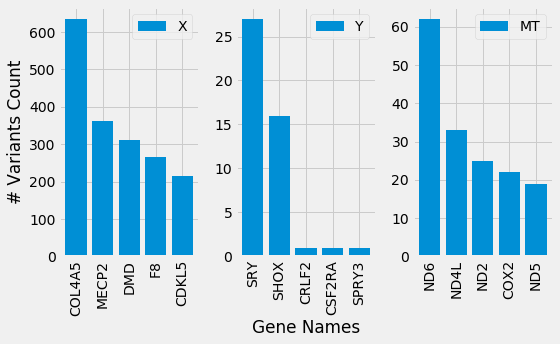

In [33]:
# Let's put this on some graphs
def plot_variant_numbers(subplot, df, genes, variant_count, chromosome):
    subplot.bar(df[genes], height = df[variant_count], label = f"{chromosome}")
    subplot.tick_params(axis = 'x', rotation = 90)
    subplot.legend()
    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (8, 5))
plot_variant_numbers(ax1, x_genes_top5, "x_genes", "x_variants_count", "X")
plot_variant_numbers(ax2, y_genes_top5, "y_genes", "y_variants_count", "Y")
plot_variant_numbers(ax3, mt_genes_top5, "mt_genes", "mt_variants_count", "MT")
ax1.set_ylabel('# Variants Count')
ax2.set_xlabel('Gene Names')

fig.tight_layout()

From this graph we can start ask other questions. For each chromosome we are going to select one gene (DMD, SRY, ND6) and determine most common diseases associated to them.

In [34]:
query_30 = """
MATCH (v:Variant {variantOf: "DMD"})-[:ASSOCIATED_WITH]->(d:Disease)
RETURN COUNT(d.diseaseName) AS numberOfDmdVariants, d.diseaseName AS dmdLinkedDiseases
ORDER BY numberOfDmdVariants DESC LIMIT 3
"""

query_31 = """
MATCH (v:Variant {variantOf: "SRY"})-[:ASSOCIATED_WITH]->(d:Disease)
RETURN COUNT(d.diseaseName) AS numberOfSryVariants, d.diseaseName AS sryLinkedDiseases
ORDER BY numberOfSryVariants DESC LIMIT 3
"""

query_32 = """
MATCH (v:Variant {variantOf: "ND6"})-[:ASSOCIATED_WITH]->(d:Disease)
RETURN COUNT(d.diseaseName) AS numberOfNd6Variants, d.diseaseName AS nd6LinkedDiseases
ORDER BY numberOfNd6Variants DESC LIMIT 3
"""

In [35]:
dmd_diseases = graph.run(query_30).to_data_frame()
sry_diseases = graph.run(query_31).to_data_frame()
nd6_diseases = graph.run(query_32).to_data_frame()

temp_df = pd.concat([dmd_diseases, sry_diseases], axis = 1)
gene_and_diseases = pd.concat([temp_df, nd6_diseases], axis = 1)

In [36]:
gene_and_diseases

,numberOfDmdVariants,dmdLinkedDiseases,numberOfSryVariants,sryLinkedDiseases,numberOfNd6Variants,nd6LinkedDiseases
0,164,Dmd-Associated Dilated Cardiomyopathy,27,"46,Xy Gonadal Dysgenesis, Complete, Sry-Related",24,Malignant neoplasm of breast
1,151,"Muscular Dystrophy, Duchenne",1,Ovotesticular Disorders of Sex Development,12,ovarian neoplasm
2,29,Becker Muscular Dystrophy,1,"46,Xy True Hermaphroditism, Sry-Related",11,"Optic Atrophy, Hereditary, Leber"


With very simple query we can quickly get the diseases with the most numbers of associated genetic variants. Let's focus on the gene `DMD`. The acronym is not really verbose but this gene codes for a protein called the **dystrophin**. Mutations in these genes are associated with X-linked dilated cardiomyopathy and Becker / Duchenne dystrophy. This is a famous disease sadly, as it affects young male individuals mostly. This is characterized by progressive muscle degeneration and weakness due to the alterations of the dystrophin. Life expectancy is strongly affected but improvement in critical care management enhanced survival into early 30. Several investigations are ongoing with notably many attempts to directly correct the mutation via gene therapy. France is one of the leader in the field and focus all hope and attention. The mitochondrial gene`ND6` which codes for the **NADH dehydrogenase 6**. A complicated name for a critical enzyme that is at the core of cellular energy production through a process called oxidative phosphorylation. We can see from our table that the two first diseases are cancers. While in the case of the dystrophin it is known that mutation is the cause of the diseases, here it is more complicated. Presence of these variants will not promote cancer development. It just says that these avriants are associated with the appearance of these cancers.

## Diving more into the dataset

In this part we are going to dive more into the dataset and will try to answer the following questions:
- *Q1*: What are the top10 genes with the most genetic variants and their associated diseases or phenotypes
- *Q2*: What are the most and less pleiotropic (associated with multiple diseases) genes?


### Q1: What are the top10 genes with the most genetic variants and their associated diseases or phenotypes

#### For diseases

In [39]:
query_35 = """
MATCH (v:Variant)-[:ASSOCIATED_WITH]->(d:Disease)
RETURN COUNT(v) AS number_of_variants, v.variantOf AS genes, d.diseaseName AS disease_name
ORDER BY number_of_variants DESC LIMIT 10
"""

variants_in_diseases = graph.run(query_35).to_data_frame()

In [40]:
variants_in_diseases

,number_of_variants,genes,disease_name
0,2632,BRCA2,"BREAST-OVARIAN CANCER, FAMILIAL, SUSCEPTIBILIT..."
1,2212,BRCA1,"BREAST-OVARIAN CANCER, FAMILIAL, SUSCEPTIBILIT..."
2,1160,BRCA2,Hereditary Breast and Ovarian Cancer Syndrome
3,1026,LDLR,"Hypercholesterolemia, Familial"
4,980,FBN1,Marfan Syndrome
5,860,BRCA1,Hereditary Breast and Ovarian Cancer Syndrome
6,791,NF1,Neurofibromatosis 1
7,542,CFTR,Cystic Fibrosis
8,503,ULK4,Multiple Myeloma
9,459,MSH2,Hereditary Nonpolyposis Colorectal Cancer


For this query we can see that cancer-related diseases are the one with the highest number of associated variants. Notably we can see some key genes here, `BRCA1` and `BRCA2`, `BRCA` being an abbreviation for **BR**east **CA**ncer. These genes are involved in DNA repair. Mutations in these two genes are stronly associated with apperance of cancers (notably breast and ovarian tumors). Another sadly famous disease is Cystic fibrosis and its gene `CFTR`. We can also observed in this top10 that a lot of mutations have been identified and associated with a metabolic disease called `familial Hypercholesterolemia` that is assocaited with pathological levels of cholesterol in blood of affected individuals.

Let's do now the same exercises but with our `Phenotype` node.

#### For Phenotypes

In [41]:
query_36 = """
MATCH (v:Variant)-[:IMPACTS_on]->(p:Phenotype)
RETURN COUNT(v) AS number_of_variants, v.variantOf AS genes, p.phenotypeName AS observed_phentoype
ORDER BY number_of_variants DESC LIMIT 10
"""

variants_in_phenotypes = graph.run(query_36).to_data_frame()

In [42]:
variants_in_phenotypes

,number_of_variants,genes,observed_phentoype
0,319,LDLR,Hypercholesterolemia result
1,277,SLC2A9,Uric acid measurement (procedure)
2,248,LDLR,Low density lipoprotein increased
3,240,KANSL1,Corpuscular Hemoglobin Concentration Mean
4,188,ALDH1A2,Serum albumin measurement
5,163,DOCK7,Serum albumin measurement
6,163,LINC02210-CRHR1,Corpuscular Hemoglobin Concentration Mean
7,161,LOC105377462,Forced expiratory volume function
8,156,CCDC162P,Corpuscular Hemoglobin Concentration Mean
9,138,LOC105377462,response to bronchodilator


Herein we can see that the gene `LDLR` previously identified as polymorphic gene and associated with familial Hypercholesterolemia is here associated with two clinical observations / phenotypes: 
- `Hypercholesterolemia result` & `Low density lipoprotein increased`.

Both observation relates to an increase of cholesterol in the blood of patients which clearly highlights here a link between the gene the phenotype and the disease.

### Q2: What are the most and less pleiotropic genes?

Let's imagine you are a scientist looking for its next move. You want your research to have a wide impact. You decide then to focus on genes that are described to be involved in several diseases. Our imaginary scientist could fastly find its next target among this top20:

In [43]:
query_37 = """
MATCH (v:Variant )-[:ASSOCIATED_WITH]->(d:Disease)
RETURN COUNT(DISTINCT d) AS number_of_disease, v.variantOf AS genes, d.diseaseGroup AS disease_class
ORDER BY number_of_disease DESC LIMIT 20
"""

top20_pleiotropic_genes = graph.run(query_37)
top20_pleiotropic_genes.to_data_frame()

,number_of_disease,genes,disease_class
0,29,TP53,Neoplasms
1,22,MECP2,Nervous System Diseases
2,21,SCN5A,Cardiovascular Diseases
3,21,FBN1,Cardiovascular Diseases
4,21,PTEN,Neoplasms
5,20,APC,Neoplasms
6,20,PTCH1,Not determined
7,20,PTPN11,Cardiovascular Diseases
8,19,PIK3CA,Neoplasms
9,18,FBN1,Not determined


The query we sent to our database returns the top20 genes based the number of diseases they are associated with and group by disease class. As such our scientist can quickly infer the most pleiotropic genes and the type of disease it is involved in.

## Conclusion

Herein we demonstrated the utility of Neo4J as a graph database to build, investigate and study biological network data. Most importantly the Cypher language behind Neo4J and the software environment driven by the both the company and the Open Source World makes the use of Neo4J very accessible. You can interact with Neo4J databases through any languages including Python, Ruby, Java and R. As such it allows scientist to quickly include this tool in their current pipeline. Our analysis here could have been much more thorough from a biological point of view. We chose to tackle very simple questions to avoid to much redundancy in our queries with as a main objective: be able to give a concise overview of Neo4J. Indeed Neo4J could be also used for more advanced analysis as it permits to harness advanced machine learning algorithms thanks to the use of different plugins (APOC, Neo4J Data Science Plugin). Additionnaly we could have fed our data with other data repositories going from pathway analysis to protein expression but this would definitively implies much more work and could actually lead to a scientific publication if well done. Asa final note we would like to underline a very important point when dealing with graph databases which is data modeling. Indeed we are convinced that thies the most critical step. Being able to modelize the network of interactions between different data sources, choosing the right labels, properties and relationships are critical steps to pave the way toward a good and well rounded graph database in Neo4J.